In [98]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

### Load and display image of document

https://bretahajek.com/2017/01/scanning-documents-photos-opencv/

(-0.5, 324.5, 577.5, -0.5)

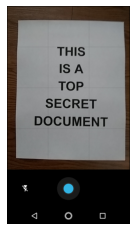

In [107]:
color_doc = cv2.cvtColor(cv2.imread("../sample_forms/top_secret.jpg"), cv2.COLOR_BGR2RGB)
doc = cv2.cvtColor(color_doc, cv2.COLOR_RGB2GRAY)

plt.imshow(color_doc, vmin=0, vmax=255)
plt.axis('off')

In [108]:
# resize image
def resize(img, height=800):
    """ Resize image to given height """
    rat = height / img.shape[0]
    return cv2.resize(img, (int(rat * img.shape[1]), height))

color_doc_scaled = resize(color_doc)
doc = resize(doc)

### Do edge detection on document

(-0.5, 448.5, 799.5, -0.5)

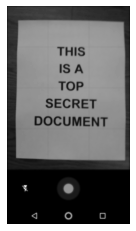

In [109]:
# Bilateral filter smooths image while preserving edges
# https://docs.opencv.org/2.4/modules/imgproc/doc/filtering.html?highlight=bilateralfilter#bilateralfilter
doc = cv2.bilateralFilter(doc, d=9, sigmaColor=75, sigmaSpace=75)

plt.imshow(doc, cmap='gray', vmin=0, vmax=255)
plt.axis('off')

(-0.5, 448.5, 799.5, -0.5)

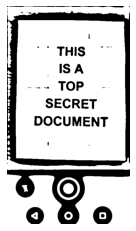

In [110]:
# Create black and white image based on adaptive threshold
# https://docs.opencv.org/2.4/modules/imgproc/doc/miscellaneous_transformations.html?highlight=adaptivethreshold
doc = cv2.adaptiveThreshold(doc, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 115, 4)

plt.imshow(doc, cmap='gray', vmin=0, vmax=255)
plt.axis('off')

(-0.5, 458.5, 809.5, -0.5)

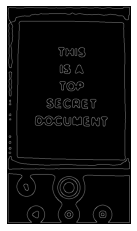

In [111]:
# Median filter clears small details
doc = cv2.medianBlur(doc, 11)	
# Add black border in case that page is touching an image border
doc = cv2.copyMakeBorder(doc, 5, 5, 5, 5, cv2.BORDER_CONSTANT, value=[0, 0, 0])	

# use canny edge detector to detect edges
#https://docs.opencv.org/2.4/modules/imgproc/doc/feature_detection.html?highlight=canny#canny
edges = cv2.Canny(doc, 200, 250)

plt.imshow(edges, cmap='gray', vmin=0, vmax=255)
plt.axis('off')

### Identify document countour / edges

In [112]:
# Find biggest convex contour w/ 4 corners
# Get contours  	
contours, hierarchy = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# set max area found to half the image size
# set page contour to entire document in case of no identifiable contours
height = edges.shape[0]	
width = edges.shape[1]	
MAX_COUNTOUR_AREA = (width - 10) * (height - 10)	

maxAreaFound = MAX_COUNTOUR_AREA * 0.5	
pageContour = None

# Find contour of biggest rectangle
for cnt in contours:
    # Simplify contour
    perimeter = cv2.arcLength(cnt, True)
    approx = cv2.approxPolyDP(cnt, 0.03 * perimeter, True)
    
    if (len(approx) == 4 and cv2.isContourConvex(approx) and maxAreaFound < cv2.contourArea(approx) < MAX_COUNTOUR_AREA):	
        maxAreaFound = cv2.contourArea(approx)	        
        pageContour = approx
        
if pageContour is None:
    raise Exception('No document detected')

(-0.5, 448.5, 799.5, -0.5)

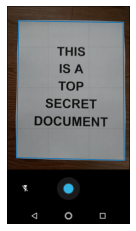

In [113]:
xs, ys = zip(*np.reshape(pageContour-5, (4,2)))
plt.imshow(color_doc_scaled, vmin=0, vmax=255)
plt.plot(xs+(xs[0],), ys+(ys[0],), linewidth=1)
plt.plot()
plt.axis('off')

### Perspective transform

(-0.5, 849.5, 1099.5, -0.5)

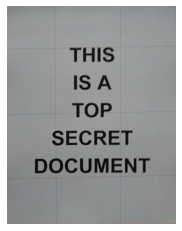

In [114]:
def fourCornersSort(pts):	 
    """ Sort corners: top-left, bot-left, bot-right, top-right """	
    # Difference and sum of x and y value
    # Inspired by http://www.pyimagesearch.com	
    diff = np.diff(pts, axis=1)	 
    summ = pts.sum(axis=1)	    	
    # Top-left point has smallest sum...	 
    # np.argmin() returns INDEX of min	  
    return np.array([pts[np.argmin(summ)],	 
                     pts[np.argmax(diff)],	  
                     pts[np.argmax(summ)],	    
                     pts[np.argmin(diff)]])	

    
def contourOffset(cnt, offset):	  
    """ Offset contour, by 5px border """
    # Matrix addition	   
    cnt += offset	 
    # if value < 0 => replace it by 0	
    cnt[cnt < 0] = 0	
    return cnt	

# Sort and offset corners
pageContour = fourCornersSort(pageContour[:, 0])	
pageContour = contourOffset(pageContour, (-5, -5))	

# Recalculate to original scale - start Points
sPoints = pageContour.dot(color_doc.shape[0] / 800)	 

# Use standard width and height
height = 1100
width = 850	
# Create target points	
tPoints = np.array([[0, 0],	      
                    [0, height],	       
                    [width, height],	         
                    [width, 0]], np.float32)	

# getPerspectiveTransform() needs float32 
sPoints = sPoints.astype(np.float32)	
    
# Wraping perspective	
M = cv2.getPerspectiveTransform(sPoints, tPoints) 
transformed_doc = cv2.warpPerspective(color_doc, M, (int(width), int(height)))

plt.imshow(transformed_doc, vmin=0, vmax=255)
plt.axis('off')

### Save transformed document

In [ ]:
cv2.imwrite("../sample_forms/less_secret.png", cv2.cvtColor(newImage, cv2.COLOR_BGR2RGB))